In [24]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from wordcloud import WordCloud, get_single_color_func
from sklearn.feature_extraction.text import CountVectorizer
import random
import seaborn as sns

def text2dict(text):
    cv = CountVectorizer(stop_words='english')
    cv_text = cv.fit_transform([text])
    return {k:v for k,v in zip(cv.get_feature_names(), cv_text.toarray().ravel())}


def topn(d, n):
    c = collections.Counter(d)
    return {k:v for k, v in c.most_common(n)}

def get_normalized_model(m, tm):
    m = np.dot(m, tm.components_)
    m-=m.mean(0)
    m-=np.min(m)
    m/=np.max(m)
    return m

class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)
    
def plot_wordle(ax, textdict, maskpath=None):
    circle = np.array(Image.open(maskpath))
    wc = WordCloud(collocations=False, max_words=100, background_color="white", mask=circle, width=2000, height=1000, colormap=plt.cm.Reds)
    wc.generate_from_frequencies(textdict)
    ax.imshow(wc.recolor(color_func=grouped_color_func, random_state=3),
           interpolation="bilinear")
    ax.axis("off")
    
def plot_image(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    im.image.axes=ax
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
#     ax.update_datalim(np.column_stack([x, y]))
#     ax.autoscale()
    return artists

cmap = plt.cm.Spectral

## Load data

In [6]:
tm = np.load('../data/topic_model')
cv = np.load('../data/count_vectorizer_model')
video_events = np.load('../data/video_events.npy')
avg_recall_events = np.load('../data/avg_recall_events.npy')

video_embeddings = np.load('../data/video_embedding.npy')
avg_recall_embedding = np.load('../data/avg_recall_embedding.npy')
recall_embeddings = np.load('../data/embeddings.npy')[:-2]
matches = np.load('../data/labels.npy')
hinge_inds = [0, 2, 4, 8, 10, 13, 16, 19, 21, 23, 27, 31, 33]

In [7]:
norm_video_events = get_normalized_model(video_events, tm)
norm_avg_recall_events = get_normalized_model(avg_recall_events, tm)

## Create the wordles

In [26]:
default_color = 'grey'
n=100
    
for seg in hinge_inds:
    weights = norm_video_events[seg,:]
    textdict_video = topn({word:weight for word, weight in zip(cv.get_feature_names(), weights)}, n)
    weights = norm_avg_recall_events[seg,:]
    textdict_recall = topn({word:weight for word, weight in zip(cv.get_feature_names(), weights)}, n)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    color_to_words = {'purple': list(set(textdict_video))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax1, textdict_video, maskpath="../data/half-moon-left.jpg")
    color_to_words = {'orange': list(set(textdict_recall))}
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)
    plot_wordle(ax2, textdict_recall, maskpath="../data/half-moon.jpg")
    plt.subplots_adjust(wspace=-.5, hspace=-.5)
    fig.patch.set_visible(False)
    plt.savefig('../figures/wordle%d.png' % seg, dpi=300)
    plt.close()

## Create figure

/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


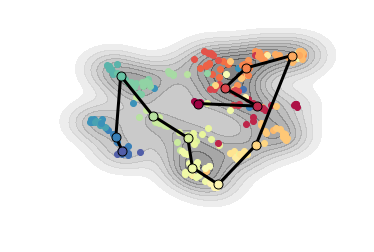

In [23]:
c = cmap(np.linspace(0, 1, 10))
sub_color = cmap(np.linspace(0, 1, 17))
subj_points = np.vstack(recall_embeddings)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.kdeplot(subj_points, alpha=.5, cmap=plt.cm.gray_r, shade=True, shade_lowest=False)
for i, (sub, sub_match) in enumerate(zip(recall_embeddings, matches)):
    for j, (p, m) in enumerate(zip(sub, sub_match)):
        ax.plot(p[0], p[1], 'o', zorder=2, c=cmap(m/34), alpha=1)
hinges = avg_recall_embedding[hinge_inds, :]
for i in range(len(hinges)-1):
    ax.plot([hinges[i, 0], hinges[i+1, 0]], [hinges[i, 1], hinges[i+1, 1]], c='k', linewidth=3)
for i in range(len(hinges)):
    ax.plot(hinges[i,0], hinges[i,1], 'o', c=cmap(hinge_inds[i]/34), zorder=4, markersize=7)
ax.plot(hinges[:,0], hinges[:,1], 'ko', zorder=3, markersize=9)
# plt.plot(avg_recall_embedding[:,0], avg_recall_embedding[:,1], 'ko', alpha=.5)
# plt.plot(avg_recall_embedding[:,0], avg_recall_embedding[:,1], 'k', linewidth=2, alpha=.25)
ax.axis('off')
plt.savefig('../figures/gist.pdf')
plt.show()